In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, NMF, FactorAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

import sys
sys.path.append("../lib/")
from pathlib import Path
import os

import warnings
warnings.filterwarnings('ignore')


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier

In [72]:
def pretrained_ann_model():
    model = Sequential([
        Dense(128, input_dim=X.shape[1], activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.25),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.25),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
ann_clf = KerasClassifier(build_fn=pretrained_ann_model, epochs=250, batch_size=64, verbose=0)

In [73]:
dataset = "L_540_2022_CERB"
img_path = Path("../img/") / dataset
img_path.mkdir(parents=True, exist_ok=True)
results_path = Path("../results/") / dataset
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))
data = data.drop(columns=['file'], axis=1)

In [4]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
classifiers = [
    ('LDA', LDA()),
    
    ('PCA-LDA', Pipeline([('pca', PCA(n_components=50)),
        ('lda', LDA())])),
    
    ('NMF-LDA', Pipeline([('nmf', NMF(n_components=40, max_iter=10000)),
        ('lda', LDA())])),
    
    ('FA-LDA', Pipeline([('fa', FactorAnalysis(n_components=40, max_iter=10000)),
        ('lda', LDA())])),
    
    ('LogReg L1', LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial')),
    ('LogReg L2', LogisticRegression(penalty='l2', solver='saga', multi_class='multinomial')),
    ('SVM L1', SVC(kernel='linear', probability=True)),
    ('SVM L2', SVC(kernel='rbf', probability=True)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100)),
    ('Artificial Neural Network', ann_clf)

]

In [7]:
def nested_cv(X, y, classifiers):
    results = {}
    for name, clf in classifiers:
        scores = cross_validate(clf, X, y, cv=5, return_train_score=True, scoring=['accuracy'], n_jobs=-1)
        results[name] = scores
    return results

results = nested_cv(X, y, classifiers)

/apps/anaconda3/envs/raman/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/anaconda3/envs/raman/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/anaconda3/envs/raman/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/anaconda3/envs/raman/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/anaconda3/envs/raman/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2023-09-28 18:30:19.043516: I tensorflow/core

30/30 [==============================] - 0s 1ms/step


In [8]:
results

{'LDA': {'fit_time': array([1.4940362 , 1.6140151 , 1.60844493, 1.60992312, 1.6149888 ]),
  'score_time': array([0.00409341, 0.0028286 , 0.00309491, 0.00349998, 0.00275803]),
  'test_accuracy': array([0.39583333, 0.35      , 0.375     , 0.34583333, 0.28333333]),
  'train_accuracy': array([1., 1., 1., 1., 1.])},
 'PCA-LDA': {'fit_time': array([0.32100058, 0.27453232, 0.30660081, 0.30629873, 0.30245423]),
  'score_time': array([0.00836539, 0.00727224, 0.00798893, 0.00794148, 0.00807834]),
  'test_accuracy': array([0.5125    , 0.59166667, 0.56666667, 0.6125    , 0.6       ]),
  'train_accuracy': array([0.69479167, 0.67083333, 0.67708333, 0.65520833, 0.65833333])},
 'NMF-LDA': {'fit_time': array([12.84851456, 15.06930351,  9.1619947 , 13.97143269, 13.05818987]),
  'score_time': array([0.03561687, 0.03543139, 0.03090501, 0.03314114, 0.03335953]),
  'test_accuracy': array([0.49583333, 0.58333333, 0.57083333, 0.62083333, 0.59166667]),
  'train_accuracy': array([0.68125   , 0.66666667, 0.65937

In [29]:
ann_test_accuracy = [0.6134, 0.6589, 0.6931, 0.6895, 0.7191]   # Assuming you want to replicate this value 5 times to mimic 5-fold CV

In [34]:
ann_test_accuracy

[0.6134, 0.6589, 0.6931, 0.6895, 0.7191]

In [31]:
# Add ANN accuracy to results
results['Artificial Neural Network'] = {'test_accuracy': np.array(ann_test_accuracy)}

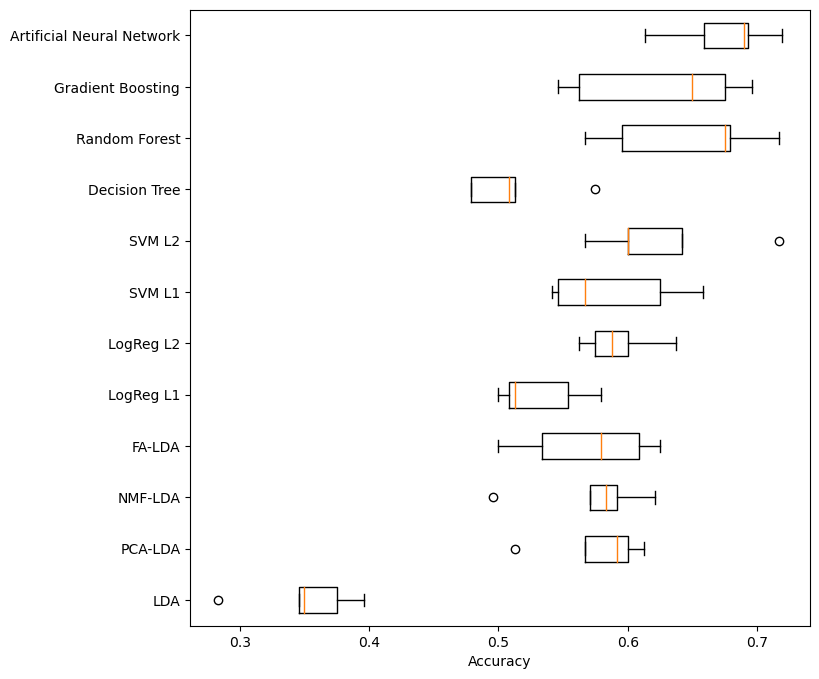

In [37]:
plt.figure(figsize=(8,8))
plt.boxplot([results[name]['test_accuracy'] for name, clf in classifiers], labels=[name for name, clf in classifiers], vert=False)
plt.xlabel('Accuracy')
plt.show()


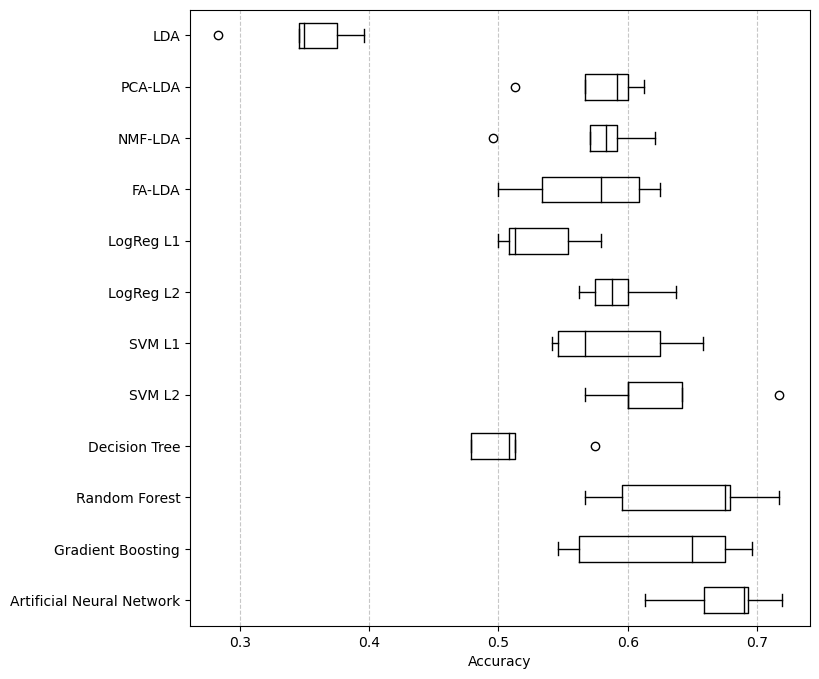

In [46]:
plt.figure(figsize=(8, 8))

# Reverse the order of classifiers and their labels
reversed_classifiers = list(reversed(classifiers))

# Create the boxplot
bp = plt.boxplot([results[name]['test_accuracy'] for name, clf in reversed_classifiers], 
                 labels=[name for name, clf in reversed_classifiers], 
                 vert=False, 
                 medianprops={'color':'black'})  # median line color

# Add grid and labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Accuracy')

# Show the plot
plt.show()


Plot saved to: ../img/L_540_2022_CERB/comp_accuracy.png


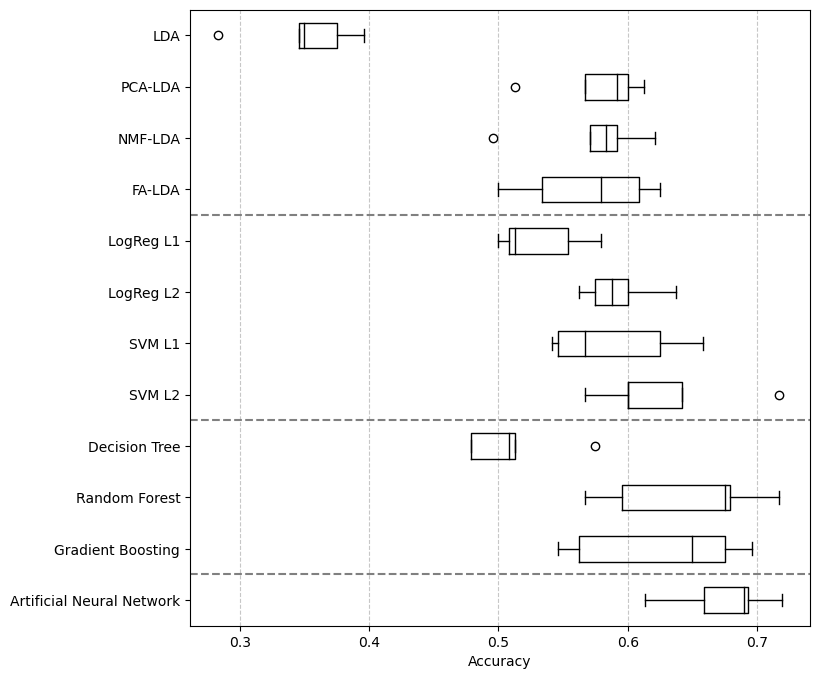

In [74]:
# Separate classifiers into categories
lda_classifiers = ['LDA', 'PCA-LDA', 'NMF-LDA', 'FA-LDA']
log_svm_classifiers = ['LogReg L1', 'LogReg L2', 'SVM L1', 'SVM L2']
tree_classifiers = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
ann_classifiers = ['Artificial Neural Network']

# Combine them in the reversed order
all_classifiers =  lda_classifiers+ log_svm_classifiers+ tree_classifiers + ann_classifiers 
all_classifiers = list(reversed(all_classifiers))

plt.figure(figsize=(8, 8))

# Create the boxplot
bp = plt.boxplot([results[name]['test_accuracy'] for name in all_classifiers], 
                 labels=[name for name in all_classifiers], 
                 vert=False, 
                 medianprops={'color':'black'})  # median line color

# Add grid and labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Accuracy')

# Add horizontal lines to separate categories
num_lda = len(lda_classifiers)
num_log_svm = len(log_svm_classifiers)
num_tree = len(tree_classifiers)
num_ann = len(ann_classifiers)

plt.axhline(y=num_lda + num_log_svm + 0.5, color='gray', linestyle='--')
plt.axhline(y=num_lda +  0.5, color='gray', linestyle='--')
plt.axhline(y=num_ann +  0.5, color='gray', linestyle='--')

plt.savefig(img_path / "comp_accuracy.png", format="png", dpi=400, bbox_inches="tight")
print(f"Plot saved to: {img_path / 'comp_accuracy.png'}")

In [ ]:
import time

def timing_with_time():
    start = time.perf_counter()
    time.sleep(1)
    end = time.perf_counter()
    print(end - start)